# Task 1: Simple example of fitting an NVP flow to a 2D dataset

Here, we will try to learn the distribution of a typical dataset called moons, which are inherently not linearly separable. We will use a normalizing flow to obtain a mapping from a standard normal distribution to our moons distribution. This is only a mock example to demonstrate the power of the normalizing flows and how to implement them on PyTorch.

## Normalizing Flow

The idea between the normalizing flows is basically to find a mapping that transforms a standard normal distribution, which is the Gaussian distribution with mean of $\mathbb{0}_n$ and covariance of $\mathbb{I}_n$ where $n$ is the dimension of the Gaussian, to the dataset we wish to learn. We want to come up with an invertible mapping so that after learning the mapping, we can also sample to mimic our dataset by sampling from the Gaussian or calculate the likelihood of observing a data point given our dataset. This property of the normalizing flows makes them perfect candidate for parameter estimation once the mapping between the dataset and the Gaussian is conditioned by the set of parameters.

A mapping in the form of 
$$\mathbf f(\mathbf{x}) = \mathbf z$$
with its inverse
$$\mathbf f^{-1}(\mathbf{z}) = \mathbf g(\mathbf{z}) = \mathbf x$$
where $\mathbf x$ is samples from the dataset and $\mathbf z$ is the normalizing variable, the distribution of the dataset we want to learn can be expressed in terms of the normalizing flow and the standart normal distribution.
$$p_\rm{data}(\mathbf{x}) = \mathcal N \left(\mathbf g(\mathbf z)| \mathbb 0, \mathbb I\right) \left| \, \det \left( \frac{\partial \mathrm g(\mathrm z)}{\partial \mathrm x} \right) \right|$$
or
$$\log\,p_\rm{data}(\mathbf{x}) =\log\, \mathcal N \left(\mathbf g(\mathbf z)| \mathbb 0, \mathbb I\right) + \log\,\left| \, \det \left( \frac{\partial \mathrm g(\mathrm z)}{\partial \mathrm x} \right) \right|$$

### RealNVP

Here, it is essential to invent a flow which will be complex enough to represent this highly-nonlinear mapping but also simple enough for the deep learning model to learn in a stable and convering way. For this, it was offered a clever way called **[RealNVP](https://arxiv.org/abs/1605.08803)** in 2016 where they use an affine coupling layer that makes the calculation of the Jacobian determinant straightforward and transform only a subset of the hidden variables to maintain invertiblity and computational efficiency.

Affine Coupling Layer:

\begin{equation}
\begin{aligned}
y_{1:d} &= x_{1:d} \\
y_{d+1:D} &= x_{d+1:D} \cdot \exp(s(x_{1:d})) + t(x_{1:d})
\end{aligned}
\end{equation}

Inverse Transformation:

\begin{equation}
\begin{aligned}
x_{1:d} &= y_{1:d} \\
x_{d+1:D} &= (y_{d+1:D} - t(y_{1:d})) \cdot \exp(-s(y_{1:d}))
\end{aligned}
\end{equation}

Log-Determinant of the Jacobian:

\begin{equation}
\log \, \left| \, \det \left( \frac{\partial y}{\partial x} \right) \right| = \sum_{i=d+1}^{D} s(x_{1:d})_i
\end{equation}

$s(x)$ and $t(x)$ are linear layers where the real learning is happening. They are respectively scale and translation functions. The question of how many of these RealNVP layers to be used is solely left to the model architect as a hyperparameter freedom. Model should minimize the negative likelihood to find to find the mapping that maximizes the likelihood of a given point from the dataset. This sounds only natural since the points coming from the dataset must be highly likely to belong to the distribution of that dataset.

### Parameter Estimation

The only remaining part in our theoretical discussion is the parameter estimation part. As you can notice, we feed no information about any parameters to the model. But this can be done with a simple modification to the definitions of the $s$ and $t$ mappings in the following way
$$\mathbf s=\mathbf s(\mathbf x; \mathbf \theta)$$
$$\mathbf t=\mathbf t(\mathbf x; \mathbf \theta)$$
where $\theta$ is the parameters to estimate.

We can now test what we discussed about the normalizing flows and RealNVP with the moons dataset.

## Coding

In [1]:
# import necessary libraries

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, distributions
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

from sklearn.datasets import make_moons

In [2]:
# path to save the plots
FIGS_DIR = os.path.join(os.getcwd(), "figs/moons/")
if not os.path.exists(FIGS_DIR):
    os.makedirs(FIGS_DIR, exist_ok=True)

# use GPU device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
def convert(x: np.array) -> torch.Tensor:
    """Converts an NumPy array to a torch Tensor
    Args:
        x (numpy.array): Input array
    Returns:
        torch.Tensor: Output tensor
    """
    # Convert a numpy array to a torch tensor with float32 entries
    return torch.as_tensor(x).float()

### Dataset

Moons distribution is basically two dividedly-labeled crescent-shaped distributions, oppositely facing each other on the xy plane in an intertwined way, where it is impossible to separate the two with a linear classifier. We will treat their labels as a model parameter and try to learn this two intertwined distribution conditioned by their label.

In [49]:
n_data = 40000     # Number of datapoints in training set

# get some training data, X coordinates and Y label
X, Y = make_moons(n_data, noise=0.05)
X_data, Y_data = X, Y

# scale the data to [-1, 1] 
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# convert it to tensors and move to device
X, Y = convert(X).to(device), convert(Y).unsqueeze(-1).to(device)

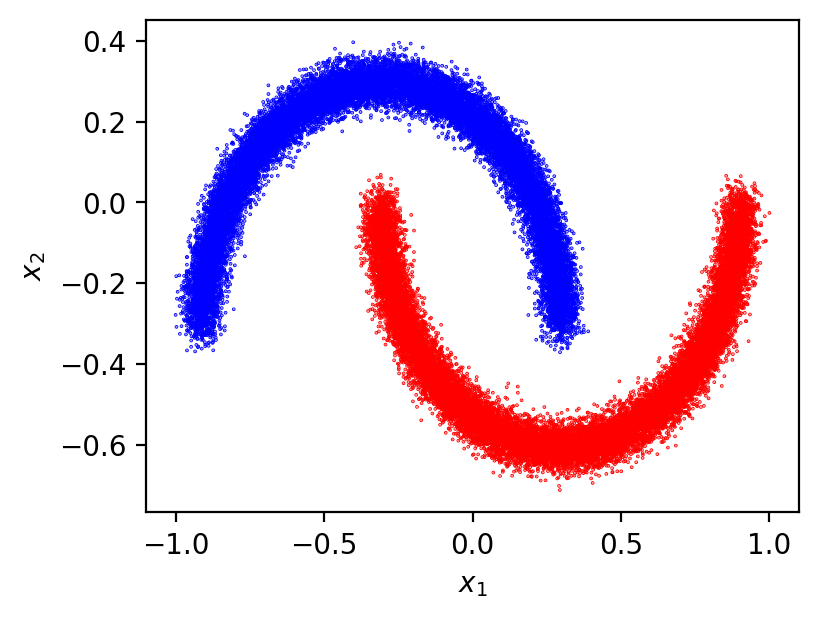

In [50]:
# plot some training samples for comparison
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4,3))
ax.scatter(*X.cpu().numpy().T, c=Y.cpu().numpy(), s=.1, cmap="bwr")
plt.tight_layout()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig(os.path.join(FIGS_DIR, "train_samples_moons.png"))
plt.show()

Here, it is shown where each data point reside on the xy plane and their colors correspond to their label.

### RealNVP Class

In [51]:
class RealNVP(nn.Module):
    def __init__(self, net_s: torch.Tensor, net_t: torch.Tensor, mask: torch.Tensor, prior: torch.distributions):
        """Creates a RealNVP network given the s and t submodules, mask tensor for calculation efficiency, and
        prior distribution for the normalizing flow.
        
        Args:
            net_s (torch.Tensor): s network for the RealNVP layer.
            net_t (torch.Tensor): t network for the RealNVP layer.
            mask (torch.Tensor): Mask tensor for easier calculations.
            prior (torch.distribution): Prior flow distribution.
        """
        super(RealNVP, self).__init__()
        # Base distribution, a data-dimensional Gaussian
        self.prior = prior
        # Masks are not to be optimised
        self.mask = nn.Parameter(mask, requires_grad=False)
        # The s and t nets that parameterise the scale and shift
        # change of variables according to inputs, here we are
        # duplicating the networks for each layer.
        self.t = torch.nn.ModuleList(
            [net_t() for _ in range(len(masks))]
        )
        self.s = torch.nn.ModuleList(
            [net_s() for _ in range(len(masks))]
        )

    def reverse(self, z: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
        """Reverse pass of the RealNVP layer.
        
        Args:
            z (torch.Tensor): Gaussian distributed z tensor.
            theta (torch.Tensor): Model parameter to be estimated.
        Returns:
            torch.Tensor: Output x tensor.
        """
        # Map from Gaussian distributed z to data x
        x = z
        for i in range(len(self.t)):
            x_ = x * self.mask[i]
            s = self.s[i](torch.cat([x_, theta], 1)) * (1 - self.mask[i])
            t = self.t[i](torch.cat([x_, theta], 1)) * (1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def forward(self, x: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
        """Forward pass of the RealNVP layer.
        
        Args:
            x (torch.Tensor): x tensor sampled from the dataset.
            theta (torch.Tensor): Model parameter to be estimated.
        Returns:
            torch.Tensor: Output z tensor.
        """
        
        # Map from data x to Gaussian distributed z
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](torch.cat([z_, theta], 1)) * (1 - self.mask[i])
            t = self.t[i](torch.cat([z_, theta], 1)) * (1 - self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self, x: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
        """Calculates log-probability of x under flow distribution.
        
        Args:
            x (torch.Tensor): x tensor passed from previous layer in forward direction.
            theta (torch.Tensor): Model parameter to be estimated.
        Returns:
            torch.Tensor: Output z tensor.
        """
        # Calculate log-probability of x under flow distribution
        z, log_det_J = self.forward(x, theta)
        return self.prior.log_prob(z) + log_det_J

    def sample(self, n: int, theta: torch.Tensor = None) -> torch.Tensor:
        """Samples n points from the learned data distribution given the parameter data. If theta is not specified it
        randomly assigns for the points.
        
        Args:
            n (int): Number of points to sample.
            theta (int, optional): Model parameter.
        Returns:
            x (torch.Tensor): Output tensor of the sampled points.
        """
        # Sample n points from flow distribution fit to data
        
        z = self.prior.sample((n, 1)).view(n,-1)
              
        theta_ = z.new_zeros((n, 1))
        if theta is None:
            theta_[:n//2] = 1
            theta_ = Y[torch.randperm(n)]
        else: theta_ = theta_ + theta
        
        x = self.reverse(z, theta_)
        
        return x

### Setup for the Training

In [52]:
H = 256            # Hidden dimension
L = 4              # Number of transforms in flow
batch_size = 2000  # Number of datapoints in batch

num_param = 1          # Number independent of parameters/labels.
data_dim = X.shape[1]  # Data dimension

# scaling and translation networks for flow change of variables
net_s = lambda: nn.Sequential(
    nn.Linear(num_param+data_dim, H), nn.LeakyReLU(),
    nn.Linear(H, H), nn.LeakyReLU(),
    nn.Linear(H, data_dim), nn.Tanh()
)
net_t = lambda: nn.Sequential(
    nn.Linear(num_param+data_dim, H), nn.LeakyReLU(),
    nn.Linear(H, H), nn.LeakyReLU(),
    nn.Linear(H, data_dim)
)

# masking for NVP flow model
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * L)).float()

# prior distribution for normalizing flow
prior = distributions.MultivariateNormal(
    torch.zeros(2).to(device), torch.eye(2).to(device)
)

# build the model
flow = RealNVP(net_s, net_t, masks, prior).to(device)

# optimizer for the model
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-5)

# splitting the dataset into train and validation subsets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Observe that the first linear model in net_s and net_t has the input dimension of num_param (1) + data_dim (2). This is how the parameter is included in the system. Masking is only a mathematical trick to simplify the forward and backward pass. Prior is chosen to be Normal distribution as discussed.

### Train

  0%|          | 0/400 [00:00<?, ?it/s]

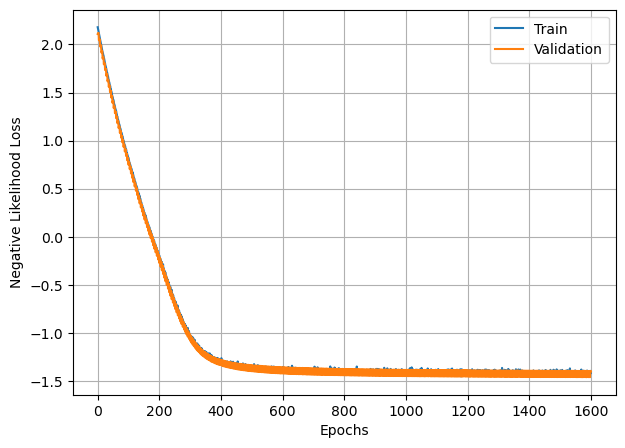

In [53]:
n_epochs = 400     # Number of batches to run for

train_losses, val_losses = [], []
T = trange(n_epochs)

for t in T:
    
    # training
    for x, y in train_dataloader:
       
        flow.train()
        loss = -flow.log_prob(x, y).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        T.set_postfix(train_loss=f"{loss:.3E}")
    
    # validation
    for x, y in val_dataloader:
        
        flow.eval()
        loss = -flow.log_prob(x, y).mean()
        
        val_losses.append(loss.item())
    
    # sampling using the model every 20 epochs
    if t % 20 == 0:

        # sample from the flow
        samples = flow.sample(2000)
        samples = samples.cpu().detach().numpy()

        fig, ax = plt.subplots(1, 1, dpi=100, figsize=(7,5))
        ax.scatter(*samples.T, s=1.)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGS_DIR, "flow_samples_moons.png"))
        plt.close()

# plot losses
plt.figure(dpi=100, figsize=(7,5))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Negative Likelihood Loss")
plt.legend()
plt.grid()
plt.savefig(os.path.join(FIGS_DIR, "loss_nvp_moons.png"))
plt.show();

### Inference

/scratch-local/slurm-job-tmp-464785/ipykernel_116/307305522.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


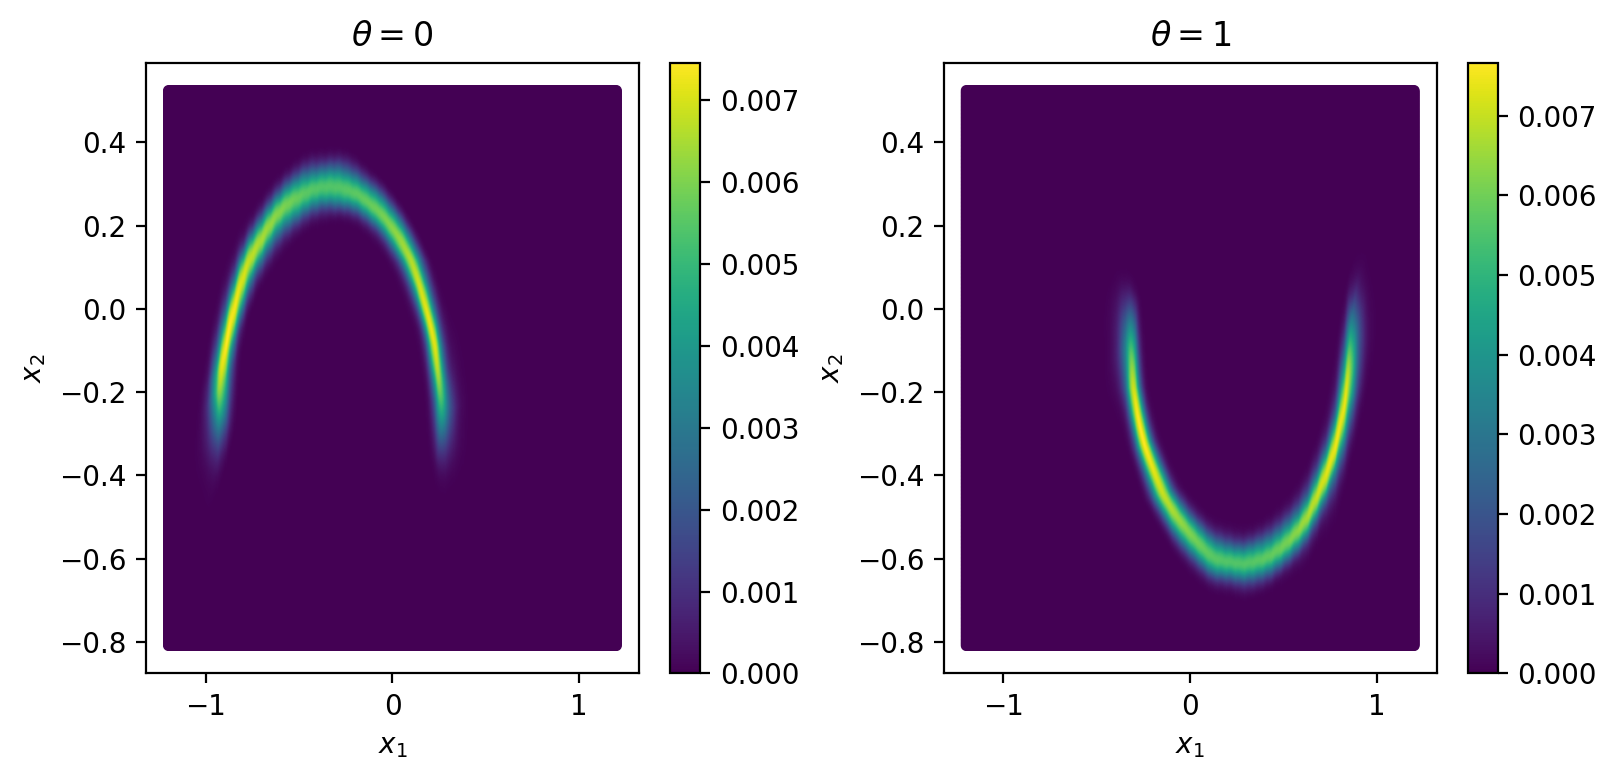

In [56]:
# now, let's look at the probabilty distribution
n = 400
X, Y = make_moons(n**2, noise=0.05)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# get a grid of points spanning the data space
X1, X2 = X.T
dx = 0.1 * (X1.max() - X1.min()) # same span as data plus a little bit extra
dy = 0.1 * (X2.max() - X2.min())
X_, Y_ = np.mgrid[X1.min() - dx:X1.max() + dx:n*1j, X2.min() - dy:X2.max() + dy:n*1j]
Y = torch.zeros(Y.shape[0], 1)
X = torch.as_tensor(np.vstack([X_.ravel(), Y_.ravel()])).float().T

# flow likelihood respectively for theta = 0 and theta = 1
L_x_0 = np.exp(flow.log_prob(X.to(device), Y.to(device)).cpu().detach().numpy())
L_x_1 = np.exp(flow.log_prob(X.to(device), Y.to(device)+1).cpu().detach().numpy())

# normalize the distributions
L_x_0, L_x_1 = L_x_0/(L_x_0.sum()*dx*dy), L_x_1/(L_x_1.sum()*dx*dy)

plt.figure(dpi=200, figsize=(8,4))

# plot for theta = 0
plt.subplot(121)
plt.scatter(*X.numpy().T, c=L_x_0, s=8.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r"$\theta=0$")
plt.tight_layout()
plt.colorbar()

# plot for theta = 1
plt.subplot(122)
plt.scatter(*X.numpy().T, c=L_x_1, s=8.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r"$\theta=1$")
plt.tight_layout()
plt.colorbar()

plt.savefig(os.path.join(FIGS_DIR, "likelihood_moons.png"))
plt.show()

Here, we search through a grid of coordinates and ask our model for the likelihood of observing a data point on that coordinate given the label. Our model seems to have learned the distribution with the parameter very well. Since this is a fairly easy problem, the region for higher likelihood almost perfectly fits with the initial data distribution for both labels.

/scratch-local/slurm-job-tmp-464785/ipykernel_116/2476303394.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/scratch-local/slurm-job-tmp-464785/ipykernel_116/2476303394.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/scratch-local/slurm-job-tmp-464785/ipykernel_116/2476303394.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


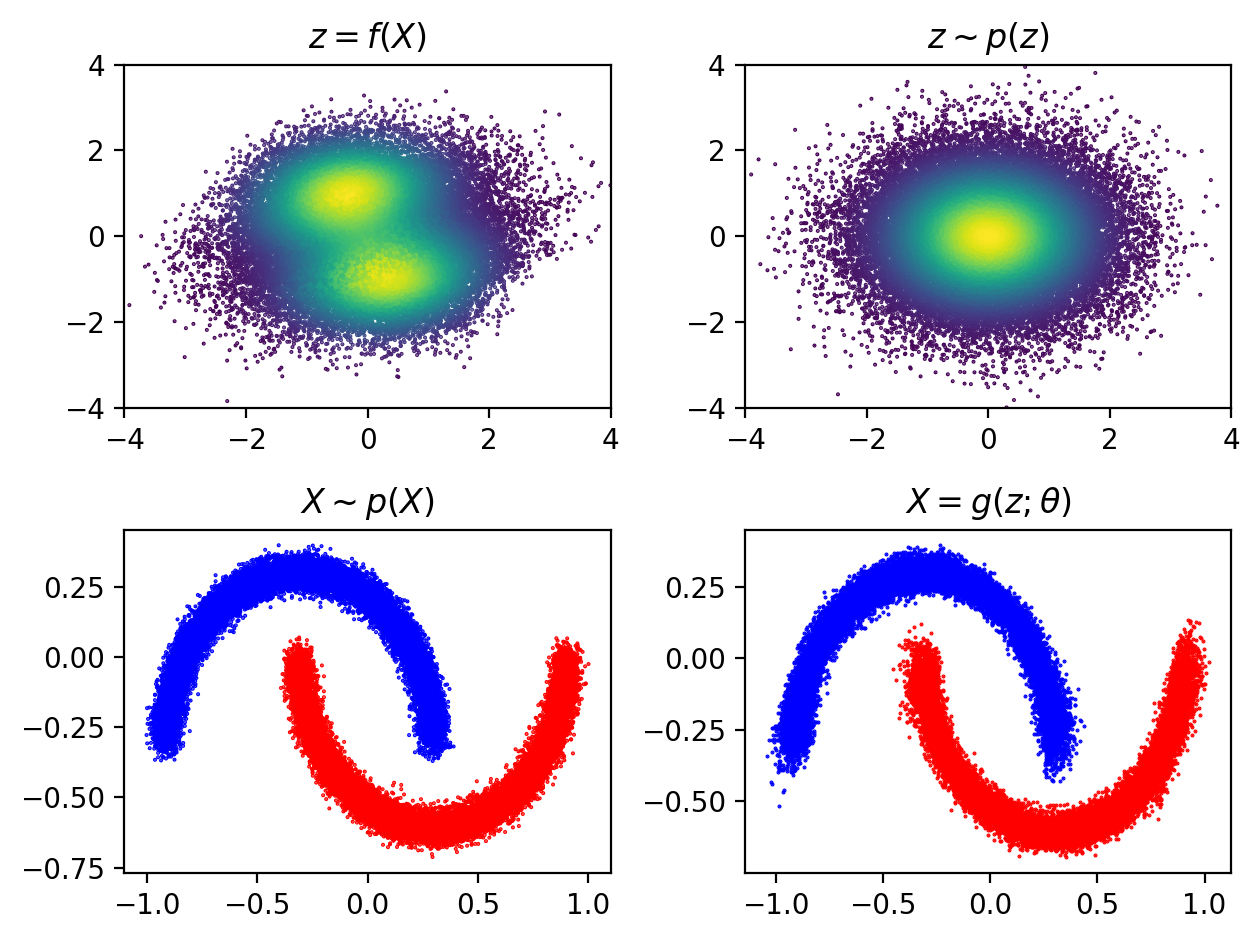

In [57]:
from scipy.stats import multivariate_normal
X, Y = X_data, Y_data
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

X = torch.as_tensor(X).float().to(device)
Y_ = convert(Y).unsqueeze(-1).to(device)

plt.figure(dpi=200)

# Data mapped to prior 'latent' space
z = flow.forward(X, Y_)[0].cpu().detach().numpy()
L_x = np.exp(flow.log_prob(X.to(device), Y_.to(device)).cpu().detach().numpy())
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1], s=0.2, c=L_x)
plt.title(r'$z = f(X)$')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.tight_layout()

# Prior
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), n_data)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1], s=0.2, c=multivariate_normal.pdf(z, [0,0], [[1,0],[0,1]]))
plt.title(r'$z \sim p(z)$')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.tight_layout()

# Truth distribution
plt.subplot(223)
X = X.cpu()
plt.scatter(X[:, 0], X[:, 1], c=Y, s=0.2, cmap="bwr")
plt.title(r'$X \sim p(X)$')
plt.tight_layout()

# Generated
plt.subplot(224)
X = flow.sample(n_data//2, 0).cpu().detach().numpy().squeeze()
plt.scatter(X[:, 0], X[:, 1], c='b', s=0.2)
X = flow.sample(n_data//2, 1).cpu().detach().numpy().squeeze()
plt.scatter(X[:, 0], X[:, 1], c='r', s=0.2)
plt.title(r'$X = g(z; \theta)$')
plt.tight_layout()

plt.savefig(os.path.join(FIGS_DIR, "flow_mappings.png"))
plt.show()

We can also observe the normalizing flow by comparing the latent space z after we forward pass the dataset with a real normal distribution. Latent space $z=f(X)$ visually looks very like a Gaussian distribution location-wise. The likelihood profile in the latent space show this two-centered characteristics, which brings the number of classes to the mind. Further training may approach and merge these centers. In the figures of the lower row, the distributions are in the same range of coordinates with very similar shapes. The sampled distribution seems to have more outlier points, but this can be avoided again with further training.